In [2]:
import warnings
warnings.filterwarnings("ignore")

import os
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from matplotlib import  pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16, DenseNet121, ResNet50, DenseNet201
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, Conv2D, MaxPool2D, BatchNormalization, Attention, Reshape, Multiply
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.models import load_model
from dataclasses import dataclass, asdict
import yaml
from typing import Optional, Union, List
from dacite import from_dict
import numpy as np
import math
import json
import itertools
import ast
import cv2
from sklearn.metrics import classification_report, confusion_matrix
import random
from random import randrange
import pandas as pd
%matplotlib inline

### checking if GPU available

In [3]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# Utilities (only run once)

In [4]:
rmdir /home/ubuntu/data/pad-ufes/images_by_class/.ipynb_checkpoints/

rmdir: failed to remove '/home/ubuntu/data/pad-ufes/images_by_class/.ipynb_checkpoints/': No such file or directory


In [23]:
# def split_dataset_into_test_and_train_sets(all_data_dir, training_data_dir, testing_data_dir, testing_data_pct):
#     # Recreate testing and training directories
#     if testing_data_dir.count('/') > 1:
#         shutil.rmtree(testing_data_dir, ignore_errors=False)
#         os.makedirs(testing_data_dir)
#         print("Successfully cleaned directory " + testing_data_dir)
#     else:
#         print("Refusing to delete testing data directory " + testing_data_dir + " as we prevent you from doing stupid things!")

#     if training_data_dir.count('/') > 1:
#         shutil.rmtree(training_data_dir, ignore_errors=False)
#         os.makedirs(training_data_dir)
#         print("Successfully cleaned directory " + training_data_dir)
#     else:
#         print("Refusing to delete testing data directory " + training_data_dir + " as we prevent you from doing stupid things!")

#     num_training_files = 0
#     num_testing_files = 0

#     for subdir, dirs, files in os.walk(all_data_dir): #https://www.geeksforgeeks.org/os-walk-python/
#         category_name = os.path.basename(subdir)

#         # Don't create a subdirectory for the root directory
#         print(category_name + " vs " + os.path.basename(all_data_dir)) #https://www.geeksforgeeks.org/python-os-path-basename-method/
#         if category_name == os.path.basename(all_data_dir):
#             continue

#         training_data_category_dir = training_data_dir + '/' + category_name #???????????????????????
#         testing_data_category_dir = testing_data_dir + '/' + category_name #???????????????????????

#         if not os.path.exists(training_data_category_dir): #???????????????????????
#             os.mkdir(training_data_category_dir)           #???????????????????????

#         if not os.path.exists(testing_data_category_dir):  #???????????????????????
#             os.mkdir(testing_data_category_dir)            #???????????????????????

#         for file in files:
#             input_file = os.path.join(subdir, file) #https://www.geeksforgeeks.org/python-os-path-join-method/
#             if np.random.rand(1) < testing_data_pct: #https://numpy.org/doc/stable/reference/random/generated/numpy.random.rand.html
#                 shutil.copy(input_file, testing_data_dir + '/' + category_name + '/' + file)
#                 #https://www.geeksforgeeks.org/python-shutil-copy-method/
#                 #shutil.copy() also copies permission bits, as well as the...
#                 #contents of the file. shutil.copyfile only copies the data.
#                 num_testing_files += 1
#             else:
#                 shutil.copy(input_file, training_data_dir + '/' + category_name + '/' + file)
#                 num_training_files += 1

#     print("Processed " + str(num_training_files) + " training files.")
#     print("Processed " + str(num_testing_files) + " testing files.")

In [24]:
# all_data_dir = '/home/ubuntu/data/pad-ufes/images_by_class/'
# training_data_dir = '/home/ubuntu/data/pad-ufes/pad_train_by_class/'
# testing_data_dir = '/home/ubuntu/data/pad-ufes/pad_test_by_class/'
# testing_data_pct = 0.2
# split_dataset_into_test_and_train_sets(all_data_dir, training_data_dir, testing_data_dir, testing_data_pct)

Successfully cleaned directory /home/ubuntu/data/pad-ufes/pad_test_by_class/
Successfully cleaned directory /home/ubuntu/data/pad-ufes/pad_train_by_class/
 vs 
mel vs 
others vs 
bcc vs 
Processed 1817 training files.
Processed 481 testing files.


### Data Augmentation and Upsampling

In [5]:
class Data_augmentation:
    def __init__(self, image):
        '''
        Import image
        :param path: Path to the image
        :param image_name: image name
        '''
        self.image = cv2.imread(image)
        #print(image)

    def rotate(self, image, angle=90, scale=1.0):
        '''
        Rotate the image
        :param image: image to be processed
        :param angle: Rotation angle in degrees. Positive values mean counter-clockwise rotation (the coordinate origin is assumed to be the top-left corner).
        :param scale: Isotropic scale factor.
        '''
        w = image.shape[1]
        h = image.shape[0]
        #rotate matrix
        M = cv2.getRotationMatrix2D((w/2,h/2), angle, scale)
        #rotate
        image = cv2.warpAffine(image,M,(w,h))
        return image

    def flip(self, image, vflip=False, hflip=False):
        '''
        Flip the image
        :param image: image to be processed
        :param vflip: whether to flip the image vertically
        :param hflip: whether to flip the image horizontally
        '''
        if hflip or vflip:
            if hflip and vflip:
                c = -1
            else:
                c = 0 if vflip else 1
            image = cv2.flip(image, flipCode=c)
        return image 
    
    
    def image_augment(self): 
        '''
        Create the new image with imge augmentation
        :param path: the path to store the new image
        ''' 
        rotate_range = [90,180]
        vflip = bool(random.randrange(2))
        hflip = bool(random.randrange(2))
        
        image = self.image
        
        image = self.rotate(image, rotate_range[random.randrange(len(rotate_range))])
        image = self.flip(image, vflip, hflip)
        return image

In [26]:
# #upsampling

# training_data_dir = '/home/ubuntu/data/pad-ufes/pad_train_by_class/'
# aug_size = 0
# rand_images = {}
# for dir in os.listdir(training_data_dir):
#     images = os.listdir(f"{training_data_dir}/{dir}")
#     images_count = len(images)
#     to_balance = aug_size - images_count
#     print(dir, images_count, to_balance)
#     rand_images[dir] = list()
#     for i in range(to_balance):
#         rand = randrange(images_count - 1)
#         rand_images[dir].append(rand)
#         img_path = f"{training_data_dir}/{dir}/{images[rand]}"
#         img_aug = Data_augmentation(img_path).image_augment()
#         cv2.imwrite(f"{img_path.split('.')[0]}_aug{i}.jpg", img_aug)

# Objects and Classes

In [6]:
@dataclass
class Resize:
    resizeW: int
    resizeH: int

@dataclass
class DullRazor:
    enabled: bool
    razorblur: str
    mediankernel_razorblur: int
    filterstructure:int
    lowerbound:int
    inpaintmat:int

@dataclass
class Blur:
    enabled: bool
    normalblur: str
    mediankernel_blur: int
    blurnum: int

@dataclass
class Softattention:
    alpha: float
    beta: float
    gamma: float
    
@dataclass
class AttentionConfig:
    resize: Resize
    dull_razor: DullRazor
    blur: Blur
    soft_attention: Softattention
        
@dataclass
class LossParams:
    func: str
    params: Optional[str]

@dataclass
class OptimizerParams:
    func: str
    params: Optional[str]

@dataclass
class InputDataParams:
    input_size: str

@dataclass
class ModelParams:
    batch_size: int
    arch: str
    freeze_pretrained: bool
    steps_per_epoch: int
    metrics: List[str]
    pretrained_weight: Optional[str]
    loss: Optional[LossParams]
    optimizer: Optional[OptimizerParams]
    class_weight_mu: float

@dataclass
class ModelsConfig:
    model_name: str
    input_params: InputDataParams
    model_params: ModelParams
    attention_config: Optional[AttentionConfig]

# Yaml for ResNet50

In [7]:
#yaml for ResNet50
yaml_config3 = """
ham_10000_resnet50:
  model_name: "HAM_10000_ResNet50"
  input_params:
    input_size: (224,224)
  model_params:
    batch_size: 32
    arch: tf.keras.applications.ResNet50
    freeze_pretrained: True
    steps_per_epoch: 100
    metrics: ['accuracy']
    loss:
      func: "sparse_categorical_crossentropy"
    optimizer:
      func: "Adam"
      params: "{'learning_rate':1e-5}"
    class_weight_mu: 1
  attention_config:
    resize:
      resizeW: 224
      resizeH: 224
    dull_razor:
      enabled: True
      razorblur: "M"
      mediankernel_razorblur: 3
      filterstructure: 5
      lowerbound: 5
      inpaintmat: 3
    blur:
      enabled: True
      normalblur: "M"
      mediankernel_blur: 5
      blurnum: 5
    soft_attention:
      alpha: 0.7
      beta: 0.3
      gamma: 0.0

ham_10000_resnet50_3D&D600450:
  model_name: "ham_10000_resnet50_3D&D600450"
  input_params:
    input_size: (600,600)
  model_params:
    batch_size: 32
    arch: tf.keras.applications.ResNet50
    freeze_pretrained: True
    steps_per_epoch: 100
    metrics: ['accuracy']
    pretrained_weight: '/home/ubuntu/data/3classes/models//ham_10000_resnet50_3D&D600450/weights.h5'
    loss:
      func: "sparse_categorical_crossentropy"
    optimizer:
      func: "Adam"
      params: "{'learning_rate':1e-4}"
    class_weight_mu: 1
  attention_config:
    resize:
      resizeW: 600
      resizeH: 600
    dull_razor:
      enabled: True
      razorblur: "M"
      mediankernel_razorblur: 3
      filterstructure: 5
      lowerbound: 5
      inpaintmat: 3
    blur:
      enabled: True
      normalblur: "M"
      mediankernel_blur: 5
      blurnum: 5
    soft_attention:
      alpha: 0.7
      beta: 0.3
      gamma: 0.0
      
ham_10k_resnet50_600450:
  model_name: "HAM_10k_ResNet50_600450"
  input_params:
    input_size: (600,450)
  model_params:
    batch_size: 32
    arch: tf.keras.applications.ResNet50
    freeze_pretrained: True
    steps_per_epoch: 100
    metrics: ['accuracy']
    loss:
      func: "sparse_categorical_crossentropy"
    optimizer:
      func: "Adam"
      params: "{'learning_rate':1e-4}"
    class_weight_mu: 1
  attention_config:
    resize:
      resizeW: 600
      resizeH: 450
    dull_razor:
      enabled: True
      razorblur: "M"
      mediankernel_razorblur: 3
      filterstructure: 5
      lowerbound: 5
      inpaintmat: 3
    blur:
      enabled: True
      normalblur: "M"
      mediankernel_blur: 5
      blurnum: 5
    soft_attention:
      alpha: 0.7
      beta: 0.3
      gamma: 0.0
      
ham_10k_resnet50_512:
  model_name: "HAM_10k_ResNet50_512"
  input_params:
    input_size: (512,512)
  model_params:
    batch_size: 32
    arch: tf.keras.applications.ResNet50
    freeze_pretrained: True
    steps_per_epoch: 100
    metrics: ['accuracy']
    loss:
      func: "sparse_categorical_crossentropy"
    optimizer:
      func: "Adam"
      params: "{'learning_rate':1e-4}"
    class_weight_mu: 1
  attention_config:
    resize:
      resizeW: 600
      resizeH: 450
    dull_razor:
      enabled: True
      razorblur: "M"
      mediankernel_razorblur: 3
      filterstructure: 5
      lowerbound: 5
      inpaintmat: 3
    blur:
      enabled: True
      normalblur: "M"
      mediankernel_blur: 5
      blurnum: 5
    soft_attention:
      alpha: 0.7
      beta: 0.3
      gamma: 0.0
      
ham_10000_resnet50_noextralayers:
  model_name: "ham_10000_resnet50_noextralayers"
  input_params:
    input_size: (600,450)
  model_params:
    batch_size: 32
    arch: tf.keras.applications.ResNet50
    freeze_pretrained: True
    steps_per_epoch: 100
    metrics: ['accuracy']
    loss:
      func: "sparse_categorical_crossentropy"
    optimizer:
      func: "Adam"
      params: "{'learning_rate':1e-4}"
    class_weight_mu: 1
  attention_config:
    resize:
      resizeW: 600
      resizeH: 450
    dull_razor:
      enabled: True
      razorblur: "M"
      mediankernel_razorblur: 3
      filterstructure: 5
      lowerbound: 5
      inpaintmat: 3
    blur:
      enabled: True
      normalblur: "M"
      mediankernel_blur: 5
      blurnum: 5
    soft_attention:
      alpha: 0.7
      beta: 0.3
      gamma: 0.0
      
ham_10000_resnet50_4D&D:
  model_name: "ham_10000_resnet50_4D&D"
  input_params:
    input_size: (600,450)
  model_params:
    batch_size: 32
    arch: tf.keras.applications.ResNet50
    freeze_pretrained: True
    steps_per_epoch: 100
    metrics: ['accuracy']
    loss:
      func: "sparse_categorical_crossentropy"
    optimizer:
      func: "Adam"
      params: "{'learning_rate':1e-4}"
    class_weight_mu: 1
  attention_config:
    resize:
      resizeW: 600
      resizeH: 450
    dull_razor:
      enabled: True
      razorblur: "M"
      mediankernel_razorblur: 3
      filterstructure: 5
      lowerbound: 5
      inpaintmat: 3
    blur:
      enabled: True
      normalblur: "M"
      mediankernel_blur: 5
      blurnum: 5
    soft_attention:
      alpha: 0.7
      beta: 0.3
      gamma: 0.0
"""


In [8]:
class Ham10000Attention:
    
    def __init__(self, model, attention_config):
        self.config = attention_config
        
        self.input_shape = (self.config.resize.resizeW, self.config.resize.resizeH)
        self.model = model
        #self.attention_output = self.heatmap(self.image, model)
    
    def resize(self, img):
        return cv2.resize(img, self.input_shape, interpolation=cv2.INTER_LINEAR)    
            
    def dull_razor(self, img):
        cfg = self.config.dull_razor
        if cfg.razorblur == "M":
            img = cv2.medianBlur(img,cfg.mediankernel_razorblur)
        elif cfg.razorblur == "G":
            img = cv2.GaussianBlur(img, (cfg.mediankernel_razorblur, cfg.mediankernel_razorblur),0)

        #gyimage = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        #filtersize = (cfg.filterstructure,cfg.filterstructure)
        #kernelrazor = cv2.getStructuringElement(cv2.MORPH_RECT, filtersize)
        #gyimage = cv2.morphologyEx(gyimage, cv2.MORPH_BLACKHAT, kernelrazor)
#
        #retrazor, maskrazor = cv2.threshold(gyimage, cfg.lowerbound, 255, cv2.THRESH_BINARY)
        #img = cv2.inpaint(img, maskrazor, cfg.inpaintmat, cv2.INPAINT_TELEA)
        return img

    def blur(self, img):
        cfg = self.config.blur
        if cfg.normalblur == "M":
            img = cv2.medianBlur(img, cfg.mediankernel_blur)
        elif cfg.normalblur == "G":
            img = cv2.GaussianBlur(img, (cfg.mediankernel_blur, cfg.mediankernel_blur), 0)
        return img

    def softention_preprocess(self, img):
        first = preprocess_input(img)
        expanded_image = np.expand_dims(first, 0)
        return expanded_image

    def softention_mapping(self, img, LayerNumber, input_shape, SoftentionImage):
        cfg = self.config.soft_attention
        activated = self.model.predict(img)
        output = np.abs(activated)
        output = np.sum(output, axis = -1).squeeze() 
        output = cv2.resize(output, input_shape)
        output /= output.max() 
        #output *= 255 
        #Weights =  255 - output.astype('uint8')
#
        #heatmap = cv2.applyColorMap(Weights, cv2.COLORMAP_JET)
        #heatmap = cv2.addWeighted(heatmap, cfg.alpha, SoftentionImage, cfg.beta, cfg.gamma)
        return output
    
    def heatmap(self, img):
        #resized_image = self.resize(img)
        hair_removed_image = self.dull_razor(img)
        softentionImage = self.blur(hair_removed_image)
        expanded_image = self.softention_preprocess(softentionImage)
        heatmap = self.softention_mapping(expanded_image, -1, self.input_shape, softentionImage)
        return heatmap
    
    def preprocess(self, img):
        
        img = self.resize(img)
        heatmap = self.heatmap(img)
        mask = heatmap.reshape(self.config.resize.resizeW,self.config.resize.resizeH,1)
        out = Multiply()([tf.cast(img, tf.float32),mask])
        img = tf.keras.utils.normalize(out)
        return img

In [9]:
class ModelTrainer():

  def __init__(self, train_dir, test_dir, model_name, model_dir, batch_size = 16, 
               target_size = (224,224), model_params = None, class_weight_mu = 0.4, 
               attention_config = None,retrain = False, model_weights = "imagenet"):
    self.train_dir = train_dir
    self.test_dir = test_dir
    self.batch_size = batch_size
    self.target_size = target_size
    self.model_name = model_name
    self.model_dir = model_dir
    self.checkpoint_path = f"{self.model_dir}/{self.model_name}"
    if attention_config:
        print("attention model")
        self.attention_model = self.attention(attention_config)
    else:
        self.attention_model = None
    self.train_generator, self.validation_generator, self.attention_generator = self.get_generators()
    self.set_class_weight(class_weight_mu)
    self.model_params = model_params
    self.retrain = retrain
    self.model_weights = model_weights
    if retrain == True or not(self.load_trained_model()):
      if model_params:
        self.register_model(self.model_architecture(model_params))
    self.class_indices = self.train_generator.class_indices
    self.index_to_class = {self.class_indices[k]:k for k in self.class_indices}


    
  @staticmethod
  def load_from_config(config, base_dir = '/home/ubuntu/data/3classes/', train_dir = "HAM10000_train_by_class", 
                       test_dir = "HAM10000_test_by_class",
                       retrain = False,
                       model_weights = "imagenet"):
    train_dir = f"{base_dir}/{train_dir}/"
    test_dir = f"{base_dir}/{test_dir}/"
    model_dir = f"{base_dir}/models"
    cfg = from_dict(data_class=ModelsConfig, data=config)
    model_trainer = ModelTrainer(train_dir, test_dir, cfg.model_name, model_dir, batch_size = cfg.model_params.batch_size or 16,
                                 target_size = eval(cfg.input_params.input_size),class_weight_mu = cfg.model_params.class_weight_mu,
                                 model_params = cfg.model_params, attention_config = cfg.attention_config, retrain = retrain, 
                                 model_weights = model_weights)    
    return model_trainer

  @classmethod
  def img_normalize(cls,img, mean, sd):
    #img = cv2.imread(img)
    #mean = [0.5456423, 0.5700427, 0.7630366]
    #sd = [0.15261365, 0.16997027, 0.14092803]
    img = cv2.resize(img, (224,224))
    img = img.astype('float32')/255.
    img = (img - mean) / sd
    #img = cv2.normalize(img, None, 0, 1, cv2.NORM_MINMAX)
    return img     
  
  def attention(self, attention_config):
    attention_pretrained_model = ResNet50(input_shape=(224,224, 3),
                                                include_top=False,
                                                weights='imagenet')
    out_layer = attention_pretrained_model.layers[-1]
    model = tf.keras.models.Model(inputs = attention_pretrained_model.inputs, outputs = out_layer.output)
    return Ham10000Attention(model,attention_config)
  
  def register_model(self, model):
    self.model = model
    self.model.compile(loss=self.model_params.loss.func, optimizer=self.optimizer(), metrics=self.model_params.metrics)
    if not os.path.exists(self.checkpoint_path):
        os.makedirs(self.checkpoint_path)
    if self.retrain:
        self.model.save(f"{self.checkpoint_path}/model.h5")
    else:
        self.load_trained_model()
        self.model.save(f"{self.checkpoint_path}/model.h5")

  def optimizer(self):
    optimizer_func = eval(self.model_params.optimizer.func)
    optimizer_params = ast.literal_eval(self.model_params.optimizer.params)
    optimizer = optimizer_func(**optimizer_params)
    return optimizer

  def summary(self):
    self.model.summary()

  def show_samples(self, rows = 4, columns = 4):
    x, y = next(self.train_generator)
    fig = plt.figure(figsize=(8, 8))
    for i in range(0, columns*rows):
      img = x[i].astype(int)
      fig.add_subplot(rows, columns, i+1)
      plt.imshow(img)
    plt.show()
  
  def get_generators(self):
    self.train_datagen = ImageDataGenerator(
                                  featurewise_center=True, 
                                  featurewise_std_normalization=True
                                  #rotation_range = 20,
                                  #width_shift_range = 0.2,
                                  #height_shift_range = 0.2,
                                  #shear_range = 0.2,
                                  #horizontal_flip = True,
                                  #vertical_flip = True,
                                  #preprocessing_function = ModelTrainer.img_normalize)
                                  #preprocessing_function = self.attention_model.preprocess
                                  #self.attention_model.preprocess)
                                  #fill_mode = 'nearest'
                                    )
    self.test_datagen = ImageDataGenerator(
                                     featurewise_center=True, 
                                    featurewise_std_normalization=True
                                    #preprocessing_function = self.attention_model.preprocess
                                     )
    if self.attention_model:
        attention_generator = ImageDataGenerator(preprocessing_function = self.attention_model.heatmap)
    else:
        attention_generator = None
    
    train_generator = self.train_datagen.flow_from_directory(directory=self.train_dir, class_mode='sparse',shuffle=True,
                                                  batch_size=self.batch_size,target_size=self.target_size)
    validation_generator = self.test_datagen.flow_from_directory(directory=self.test_dir, class_mode='sparse',shuffle=False,
                                                       batch_size=self.batch_size,target_size=self.target_size)
    return train_generator, validation_generator, attention_generator
 
  def create_class_weight(self, labels_dict, mu):
    total = np.sum(list(labels_dict.values()))
    keys = labels_dict.keys()
    class_weight = dict()
    
    for key in keys:
      score = math.log(mu*total/float(labels_dict[key]))
      score = mu*total/float(labels_dict[key])
      class_weight[key] = score if score > 1.0 else 1.0
    return class_weight

  def set_class_weight(self, mu):  
    class_dict = dict()
    for dir in os.listdir(self.train_dir):
      class_dict[dir] = len(os.listdir(f"{self.train_dir}/{dir}"))

    weights = self.create_class_weight(class_dict, mu)
    self.class_weight = {}
    class_indices = self.train_generator.class_indices
    for cls in weights:
      self.class_weight[class_indices[cls]] = weights[cls]
  
  def _callback(self):
    filepath = self.checkpoint_path + '/weights.h5'
    checkpoint_dir = os.path.dirname(self.checkpoint_path)
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=filepath,
                                                    save_weights_only=True,
                                                    verbose=2,
                                                    save_best_only=True)
    learning_rate_reduction = ReduceLROnPlateau(monitor='loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
    return [cp_callback,learning_rate_reduction]
  
  def model_architecture(self, model_params, CLASS_N = 3):
    
    arch = eval(model_params.arch)
    input_shape =  (self.target_size[0],self.target_size[1],3)
    pretrained = arch(input_shape = input_shape, include_top=False, weights=model_params.pretrained_weight or None)

    for layer in pretrained.layers:
      layer.trainable = not(model_params.freeze_pretrained)
    
    x = Flatten()(pretrained.layers[-1].output)
    #x = Dense(5000, kernel_regularizer=regularizers.l1_l2(0.00001), activity_regularizer=regularizers.l2(0.00001), activation='relu',kernel_initializer=tf.keras.initializers.he_normal())(x) 
    #x = Dropout(0.5)(x)
    x = BatchNormalization()(x)
    x = Dense(CLASS_N, activation = 'softmax')(x)
    
    model = Model(inputs = pretrained.input, outputs = x)
    print("New model created")
    return model
  
  def load_trained_model(self):
    if os.path.exists(self.checkpoint_path):
      print("Trained model exists and it will be loaded")
      if self.model_weights == "imagenet":
          self.model = load_model(f'{self.checkpoint_path}/model.h5')
          self.model.load_weights(f'{self.checkpoint_path}/weights.h5')
          print(f"Using weights from {self.checkpoint_path}")
      else:
          self.model = load_model(f'{self.model_weights}/model.h5')
          self.model.load_weights(f'{self.model_weights}/weights.h5')
          print(f"Using weights from {self.model_weights}")
      self.model.compile(loss=self.model_params.loss.func, optimizer=self.optimizer(), metrics=self.model_params.metrics)
      return True
    return False
  
  def train(self, epochs=10, verbose=2):
    with tf.device('/device:GPU:0'):
      model_info = self.model.fit(
                      x=self.train_generator, 
                      steps_per_epoch=self.train_generator.samples // self.batch_size+1,  
                      epochs=epochs, 
                      validation_steps=self.validation_generator.samples // self.batch_size+1,
                      validation_data=self.validation_generator, 
                      verbose=verbose,
                      callbacks=self._callback(),
                      class_weight=self.class_weight
                  )
      self.model_info = model_info
      with open(f'{self.model_dir}/history.json','w') as fp:
        json.dump(str(self.model_info.history), fp)
    
  def confusion_matrix(self):    
    Y_pred = self.model.predict(self.validation_generator, self.validation_generator.samples // self.batch_size+1)
    y_pred = np.argmax(Y_pred, axis=1)
    cm = confusion_matrix(self.validation_generator.classes, y_pred)
    target_names = list(self.validation_generator.class_indices.keys())
    cls_rpt = classification_report(self.validation_generator.classes, y_pred, target_names=target_names)
    #self.plot_confusion_matrix(cm, target_names)

  def predict(self, image):
    img = cv2.imread(image)
    img = cv2.resize(img, dsize=self.target_size)
    img = img.reshape((1, self.target_size[0], self.target_size[1], 3))
    
    predict_gen = self.test_datagen.flow(img, batch_size=1)
    prob = self.model.predict(predict_gen)
    arg_max = np.argmax(prob)
    pred = self.index_to_class[arg_max]
    return pred, prob[0][arg_max], prob

  def get_test_generator(self,directory):
    test_generator = self.test_datagen.flow_from_directory(directory=directory, class_mode='sparse',shuffle=False,
                                                       batch_size=self.batch_size,target_size=self.target_size)
    return test_generator
    
  def plot_confusion_matrix(self, test_data_directory=None):
    
    normalize=False
    title='Confusion matrix'
    cmap=plt.cm.Blues
    
    if test_data_directory == None:
        generator = self.validation_generator
    else:
        generator = self.get_test_generator(test_data_directory)
    
    Y_pred = self.model.predict(generator, generator.samples // self.batch_size+1)
    y_pred = np.argmax(Y_pred, axis=1)
    cm = confusion_matrix(generator.classes, y_pred)
    classes = list(generator.class_indices.keys())
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')  
    #print(set(y_pred))
    
    cls_rpt = classification_report(generator.classes, y_pred, target_names=classes)
    print(cls_rpt)

# ResNet extra layers function

In [10]:
#visit here for more info on parameters: https://keras.io/api/applications/resnet/#resnet50-function
# ResNet50 function
def ham_10000_resnet50(CLASS_N=3, weights = "imagenet"):
    
    #model pre-trained on imagenet dataset
    resnet_base = ResNet50(input_shape = (600,450,3), weights = weights,  #when changing model arch yaml input size ==function input size
                           include_top = False, pooling = 'avg') 
    #When loading a given model, the “include_top” argument can be set to False, ...
    #in which case the fully-connected output layers of the model used to make predictions is ...
    #not loaded, allowing a new output layer to be added and trained.
    
    for layer in resnet_base.layers:
        layer.trainable = False
        #trainable to False moves all the layer's weights from trainable to non-trainable...
        #This is called "freezing" the layer: the state of a frozen layer won't be updated during ...
        #training (either when training with fit() or when training with any custom loop that relies ...
        #on trainable_weights to apply gradient updates).
        
    x = Flatten()(resnet_base.layers[-1].output)
    x = Dense(512,activation = 'relu', kernel_regularizer = regularizers.l2(0.001))(x)#regulariser reduces overfitting
    x = Dropout(0.5)(x) #50% change in the output of neuron made 0 # also reduces overfitting
    x = Dense(512, activation = 'relu', kernel_regularizer = regularizers.l2(0.001))(x)#regulariser reduces overfitting
    x = Dropout(0.5)(x) #50% change in the output of neuron made 0 # also reduces overfitting
    x = Dense(CLASS_N, activation = 'softmax', kernel_regularizer = regularizers.l2(0.001))(x)
    
    model = Model(inputs = resnet_base.input, outputs = x)
    
    return model

# ResNet50 run on padufes

## Running ham_10k_resnet50_600450 on HAM10000 dataset for model training
## WARNING!!!: Running this chunk resets current model weights

In [32]:
# name = 'ham_10k_resnet50_600450'
# model_config3 = yaml.safe_load(yaml_config3)
# model_trainer = ModelTrainer.load_from_config(model_config3[name], '/home/ubuntu/data/3classes', 
#                                               train_dir = "HAM10000_train_by_class", test_dir = "HAM10000_test_by_class",
#                                               retrain = True, #will override saved model weights
#                                               model_weights = "/home/ubuntu/data/3classes/models/ham_10k_resnet50_600450"
#                                              )

# #set class weights (these are case sensitive)
# class_indices = model_trainer.train_generator.class_indices
# model_trainer.class_weight[class_indices['bcc']] = 2.5
# model_trainer.class_weight[class_indices['mel']] = 2.5
# model_trainer.class_weight[class_indices['others']] = 1

# model3 = ham_10000_resnet50()
# model_trainer.register_model(model3)

attention model
Found 25500 images belonging to 3 classes.
Found 2051 images belonging to 3 classes.
New model created


In [33]:
# model_trainer.train(epochs=33, verbose = 1)

Epoch 1/33
797/797 [==============================] - 471s 582ms/step - loss: 2.6693 - accuracy: 0.6506 - val_loss: 1.4307 - val_accuracy: 0.7972

Epoch 00001: val_loss improved from inf to 1.43070, saving model to /home/ubuntu/data/3classes/models/HAM_10k_ResNet50_600450/weights.h5
Epoch 2/33
797/797 [==============================] - 460s 576ms/step - loss: 1.6686 - accuracy: 0.8302 - val_loss: 1.3450 - val_accuracy: 0.7460

Epoch 00002: val_loss improved from 1.43070 to 1.34505, saving model to /home/ubuntu/data/3classes/models/HAM_10k_ResNet50_600450/weights.h5
Epoch 3/33
797/797 [==============================] - 457s 574ms/step - loss: 1.3933 - accuracy: 0.8599 - val_loss: 1.0976 - val_accuracy: 0.8396

Epoch 00003: val_loss improved from 1.34505 to 1.09763, saving model to /home/ubuntu/data/3classes/models/HAM_10k_ResNet50_600450/weights.h5
Epoch 4/33
797/797 [==============================] - 478s 599ms/step - loss: 1.2080 - accuracy: 0.8761 - val_loss: 1.0503 - val_accuracy: 0

              precision    recall  f1-score   support

         bcc       0.59      0.74      0.66        95
         mel       0.47      0.78      0.59       239
      others       0.95      0.85      0.90      1717

    accuracy                           0.84      2051
   macro avg       0.67      0.79      0.71      2051
weighted avg       0.88      0.84      0.85      2051



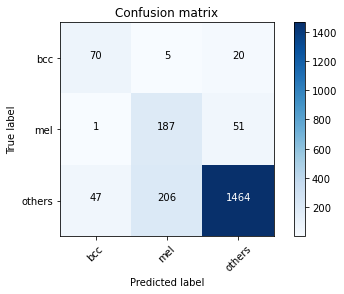

In [34]:
# model_trainer.plot_confusion_matrix()

# Testing external dataset directly with custom weighted model

Found 1817 images belonging to 3 classes.
              precision    recall  f1-score   support

         bcc       0.37      0.27      0.31       656
         mel       0.05      0.15      0.07        39
      others       0.62      0.68      0.65      1122

    accuracy                           0.52      1817
   macro avg       0.35      0.37      0.34      1817
weighted avg       0.52      0.52      0.51      1817



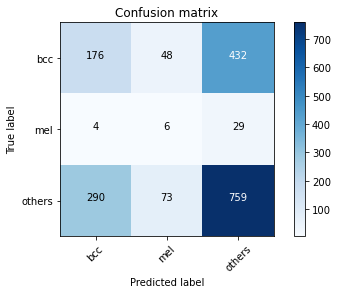

In [35]:
# to test external dataset directly
# this can be any directory but should have same class labels as the models training data
external_data_dir = r'/home/ubuntu/data/pad-ufes/pad_train_by_class/' 
model_trainer.plot_confusion_matrix(external_data_dir)

# Testing ONE external image directly with custom weighted model

In [36]:
#NEW image file directory goes here
image = r'/home/ubuntu/data/pad-ufes/pad_train_by_class/bcc/PAT_106_158_270.png'

#function which outputs probability scores of all classes and highest probability class
label, label_prob, all_labels_prob = model_trainer.predict(image)

print("Probability scores range between 0 and 1. Higher scores indicate more probability of lesion belonging to the class.""\n") 

print("\033[1m""Lesion is most likely", label, "class with a probaility of", label_prob,"\033[0m""\n")
print("All class proabilities for this lesion:",
      f"bcc - {all_labels_prob[0][0]}, mel - {all_labels_prob[0][1]}, others - {all_labels_prob[0][2]}")

Probability scores range between 0 and 1. Higher scores indicate more probability of lesion belonging to the class.

Lesion is most likely others class with a probaility of 0.97243935 

All class proabilities for this lesion: bcc - 0.027560599148273468, mel - 9.755457597293571e-08, others - 0.9724393486976624


# Training and testing on a new dataset with custom weighted ResNet50

In [11]:
#if retrain = True then imagenet is loaded for model_weights

#if retrain = False & model weights is not specified then it will use the weights of the 
    #model we trained previously using imagenet
    
#if retrain = False and model weights is specified it will reuse the weights from the directory 
   #you passed as a parameter (the model architecture for the same model must be saved)
    

    
name = 'ham_10k_resnet50_600450'
model_config3 = yaml.safe_load(yaml_config3)
model_trainer_2 = ModelTrainer.load_from_config(model_config3[name], '/home/ubuntu/data/pad-ufes', 
                                              train_dir = "pad_train_by_class", test_dir = "pad_test_by_class", #directories of new dataset to train and test
                                              retrain = False, #will keep saved model weights
                                              model_weights = "/home/ubuntu/data/3classes/models/HAM_10k_ResNet50_600450"
                                             )

#set class weights
class_indices = model_trainer_2.train_generator.class_indices
model_trainer_2.class_weight[class_indices['bcc']] = 2.5
model_trainer_2.class_weight[class_indices['mel']] = 2.5
model_trainer_2.class_weight[class_indices['others']] = 1

model3 = ham_10000_resnet50()
model_trainer_2.register_model(model3)

attention model
Found 1817 images belonging to 3 classes.
Found 481 images belonging to 3 classes.
Trained model exists and it will be loaded
Using weights from /home/ubuntu/data/3classes/models/HAM_10k_ResNet50_600450
Trained model exists and it will be loaded
Using weights from /home/ubuntu/data/3classes/models/HAM_10k_ResNet50_600450


In [12]:
model_trainer_2.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 600, 450, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 606, 456, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 300, 225, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 300, 225, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [13]:
model_trainer_2.train(epochs=33, verbose = 1)

Epoch 1/33
57/57 [==============================] - 97s 2s/step - loss: 3.2497 - accuracy: 0.5125 - val_loss: 1.1419 - val_accuracy: 0.5509

Epoch 00001: val_loss improved from inf to 1.14188, saving model to /home/ubuntu/data/pad-ufes/models/HAM_10k_ResNet50_600450/weights.h5
Epoch 2/33
57/57 [==============================] - 87s 2s/step - loss: 1.4304 - accuracy: 0.5763 - val_loss: 0.9671 - val_accuracy: 0.6091

Epoch 00002: val_loss improved from 1.14188 to 0.96711, saving model to /home/ubuntu/data/pad-ufes/models/HAM_10k_ResNet50_600450/weights.h5
Epoch 3/33
57/57 [==============================] - 87s 2s/step - loss: 1.2912 - accuracy: 0.6109 - val_loss: 0.9474 - val_accuracy: 0.6195

Epoch 00003: val_loss improved from 0.96711 to 0.94739, saving model to /home/ubuntu/data/pad-ufes/models/HAM_10k_ResNet50_600450/weights.h5
Epoch 4/33
57/57 [==============================] - 87s 2s/step - loss: 1.2022 - accuracy: 0.6490 - val_loss: 0.9174 - val_accuracy: 0.6383

Epoch 00004: val_

              precision    recall  f1-score   support

         bcc       0.68      0.77      0.72       189
         mel       0.00      0.00      0.00        13
      others       0.81      0.76      0.79       279

    accuracy                           0.74       481
   macro avg       0.50      0.51      0.50       481
weighted avg       0.74      0.74      0.74       481



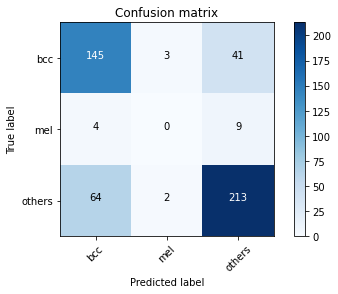

In [14]:
model_trainer_2.plot_confusion_matrix()

Found 481 images belonging to 3 classes.
              precision    recall  f1-score   support

         bcc       0.68      0.77      0.72       189
         mel       0.00      0.00      0.00        13
      others       0.81      0.76      0.79       279

    accuracy                           0.74       481
   macro avg       0.50      0.51      0.50       481
weighted avg       0.74      0.74      0.74       481



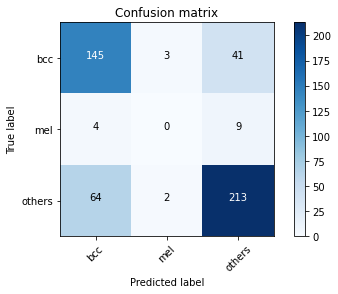

In [15]:
# Testing external dataset directly with custom weighted ResNet50
# to test external dataset directly
# this can be any directory but should have same class labels as the models training data
# external_data_dir = r'/home/ubuntu/data/pad-ufes/pad_train_by_class/' 
external_data_dir = r'/home/ubuntu/data/pad-ufes/pad_test_by_class/'
model_trainer_2.plot_confusion_matrix(external_data_dir)

In [16]:
# Testing ONE external image directly with custom weighted ResNet50
#NEW image file directory goes here
image = r'/home/ubuntu/data/pad-ufes/pad_train_by_class/bcc/PAT_106_158_270.png'

#function which outputs probability scores of all classes and highest probability class
label, label_prob, all_labels_prob = model_trainer_2.predict(image)

print("Probability scores range between 0 and 1. Higher scores indicate more probability of lesion belonging to the class.""\n") 

print("\033[1m""Lesion is most likely", label, "class with a probaility of", label_prob,"\033[0m""\n")
print("All class proabilities for this lesion:",
      f"bcc - {all_labels_prob[0][0]}, mel - {all_labels_prob[0][1]}, others - {all_labels_prob[0][2]}")

Probability scores range between 0 and 1. Higher scores indicate more probability of lesion belonging to the class.

Lesion is most likely others class with a probaility of 0.99868196 

All class proabilities for this lesion: bcc - 0.0013179490342736244, mel - 3.377903823320594e-08, others - 0.9986819624900818


In [20]:
rmdir /home/ubuntu/data/isic-2019/images_by_class/.ipynb_checkpoints/

Found 25331 images belonging to 3 classes.
              precision    recall  f1-score   support

         bcc       0.29      0.45      0.36      3323
         mel       0.52      0.16      0.25      4522
      others       0.75      0.80      0.77     17486

    accuracy                           0.64     25331
   macro avg       0.52      0.47      0.46     25331
weighted avg       0.65      0.64      0.63     25331



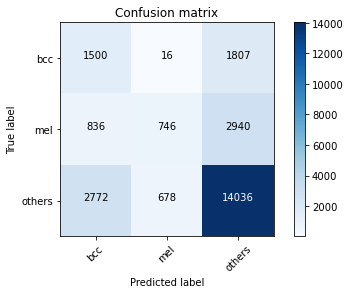

In [21]:
external_data_dir = r'/home/ubuntu/data/isic-2019/images_by_class/'
model_trainer_2.plot_confusion_matrix(external_data_dir)

In [22]:
# Testing ONE external image directly with custom weighted ResNet50
#NEW image file directory goes here
image = r'/home/ubuntu/data/pad-ufes/pad_train_by_class/bcc/PAT_106_158_270.png'

#function which outputs probability scores of all classes and highest probability class
label, label_prob, all_labels_prob = model_trainer_2.predict(image)

print("Probability scores range between 0 and 1. Higher scores indicate more probability of lesion belonging to the class.""\n") 

print("\033[1m""Lesion is most likely", label, "class with a probaility of", label_prob,"\033[0m""\n")
print("All class proabilities for this lesion:",
      f"bcc - {all_labels_prob[0][0]}, mel - {all_labels_prob[0][1]}, others - {all_labels_prob[0][2]}")

Probability scores range between 0 and 1. Higher scores indicate more probability of lesion belonging to the class.

Lesion is most likely others class with a probaility of 0.99868196 

All class proabilities for this lesion: bcc - 0.0013179490342736244, mel - 3.377903823320594e-08, others - 0.9986819624900818
